AAS Convex Trajectory Update 

In [9]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
import copy
# seaborn.set_style("whitegrid")
from scipy.io import loadmat, savemat
from scipy.interpolate import interp1d 

print(plt.style.available)
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-whitegrid')

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', '_classic_test']


In [2]:
from EntryGuidance import EntryEquations as EE
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute, InitialState
from EntryGuidance.Simulation import Simulation, Cycle
from EntryGuidance.Triggers import AccelerationTrigger, VelocityTrigger, RangeToGoTrigger, SRPTrigger
from Utils import gpops 
from Utils.submatrix import submatrix 
from Utils.smooth import smooth 

In [31]:
x0 = InitialState.InitialState(rtg=870e3)
model = EE.Entry()
target = model.planet.coord(x0[1], x0[2], 0, dr=870e3, cr=0e3)
print("Initial State: {}".format(x0))
print("Target: {}".format(target))

Initial State: [ 3.54000000e+06  0.00000000e+00  0.00000000e+00  5.50500000e+03
 -2.46964089e-01  0.00000000e+00  8.70000000e+05  2.80400000e+03]
Target: (0.25610833088018825, 1.551123825447439e-17)


In [4]:
def get_opt_traj(x0, bank, target):
    y0 = [float(x) for x in x0[:6]]
    target = [float(t) for t in target]
    traj = gpops.EG([y0, float(bank), target[0], target[1]])
    return traj

def plot_gpops(x, label='', figsize=(10,6), fontsize=18, linespec={}):
#     x = np.array(traj['state'])
    r,th,ph,v,fpa,heading,bank = x.T
    
    h = r/1000 - 3397
    dr = th*3397
    cr = -ph*3397
    
    opts = {'fontsize' : fontsize}
    
    plt.figure(1, figsize=figsize)
    plt.plot(v, h, label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Altitude (km)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(2, figsize=figsize)
    plt.plot(dr, cr, label=label, **linespec)
    plt.xlabel('Downrange (km)', **opts)
    plt.ylabel('Crossrange (km)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(3, figsize=figsize)
    plt.plot(v, np.degrees(fpa), label=label, **linespec)
    plt.xlabel('Velocity', **opts)
    plt.ylabel('FPA (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(4, figsize=figsize)
    plt.plot(v, np.degrees(heading), label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Heading (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.figure(5, figsize=figsize)
    plt.plot(v, np.degrees(bank), label=label, **linespec)
    plt.xlabel('Velocity (m/s)', **opts)
    plt.ylabel('Bank Angle (deg)', **opts)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

In [5]:
traj = get_opt_traj(x0, 0., target)
# plot_gpops(np.array(traj['state']))

In [6]:
class ConvexPC(object):
    """ Simply commands the current open loop plan until triggered otherwise 

    """
    def __init__(self, traj, tspan=30):
        
        self.history = []
        self.t_replan = []
        self.x_replan = []
        self.bank_replan = []
        self.tspan = tspan
        self.set_profile(traj)
        self.target = self.history[0][-1, 1:3]
        
    def controller(self, time, velocity, current_state, bank, **kwargs):
        
        if not self.t_replan:
            self.t_replan.append(time)
            self.x_replan.append(current_state)
            self.bank_replan.append(bank)
            
        if self.trigger(time, velocity):
            self.t_replan.append(time)
            self.x_replan.append(current_state)
            self.bank_replan.append(bank)
            
            print("Replanning...")
            traj = get_opt_traj(current_state, bank, self.target)
            print("    ...done")
            self.set_profile(traj)
            
        return self.profile(velocity)
        
        
    def trigger(self, time, velocity):
        return time - self.t_replan[-1] >= self.tspan and velocity > 600
        
    def set_profile(self, traj):
        x = np.array(traj['state'])
        self.history.append(x)
        
        r,th,ph,v,fpa,heading,bank = x.T
        
        self.profile = interp1d(v, bank, kind='cubic', axis=0, copy=True, bounds_error=False, fill_value=(bank[-1], bank[0]), assume_sorted=False)
        
        
    def plot_history(self,):
        # each element is a full set of states
        plot_gpops(self.history[0], label="Nominal")

        for i,(x,b,traj) in enumerate(zip(self.x_replan, self.bank_replan, self.history)):
            y = np.append(x[0:6], b)
            plot_gpops(y, linespec={'marker':'o', 'markersize':9}) #label="Update {}".format(i+1), 
            plot_gpops(traj) # label="Update {}".format(i)
        
        
    def plot_traj(self, sim, save=False, fontsize=16):
        plot_gpops(self.history[0], label="Nominal",fontsize=fontsize,linespec={'linewidth':3})
        traj_ = np.concatenate((sim.history[:,0:6], sim.control_history[:,0:1]), axis=1)
        plot_gpops(traj_, label="Flown", fontsize=fontsize, linespec={'linewidth':3})
        
        for i,(x,b) in enumerate(zip(self.x_replan, self.bank_replan)):
            y = np.append(x[0:6], b)
            plot_gpops(y, linespec={'marker':'o', 'color':'black','markersize':9}) #label="Update {}".format(i+1),
        
        names = ["AltVel","DRCR","FPA","Heading","Bank"]
        for i in range(1,6):
            plt.figure(i)
            plt.legend(fontsize=14)
            
            if save:
                plt.savefig("./results/convex/{}.png".format(names[i-1]), bbox_inches='tight')

            
        

In [49]:
conditions = [AccelerationTrigger('drag', 2), SRPTrigger(0, 480, 1000)]
states = ["Drag < 2 m/s^2", "Guided Entry"]
sim = Simulation(cycle=Cycle(1), output=True, **{ 'states' : states,
              'conditions' : conditions })


OL = ConvexPC(traj, 1e6) # never replans, just open loop essentially
CL = ConvexPC(traj, tspan=10)
res = sim.run(copy.deepcopy(x0), [OL.controller, CL.controller], [.05, .07, -.0168,.00014])
# sim.plot(compare=False)

Resetting simulation states.

L/D: 0.24
BC : 115.80401829293542 kg/m^2
current simulation time = 0 s
current simulation time = 10 s
current simulation time = 20 s
current simulation time = 30 s
current simulation time = 40 s
current simulation time = 50 s
current simulation time = 60 s
Transitioning from state Drag < 2 m/s^2 to Guided Entry because the following condition was met:
Drag >= 2 m/s^2
None
time : 65.78368421052632

altitude : 64856.28275389969

longitude : 0.1014971876973853

latitude : 2.2575686865696815e-07

velocity : 5536.818800831475

fpa : -0.18533817795748272

heading : 1.747333401776871e-05

rangeToGo : 525214.0533919826

mass : 2804.0

drag : 2.0004682573338353

lift : 0.49062334884296077

planet : <EntryGuidance.Planet.Planet object at 0x00000239E1730C88>

aero_ratios : (1, 1)

bank : -0.028339190931822068

energy : 15564389.73012293

disturbance : 0

current simulation time = 69 s
Replanning...
    ...done
current simulation time = 79 s
Replanning...
    ...done


E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in double_scalars
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


In [ ]:
CL.plot_traj(sim, save=True)

In [ ]:
CL.plot_history()

In [32]:
def uncertainty(K=1): # MSL-like dispersions, according to Soumyo Dutta paper on reconstruction 
        import chaospy as cp 
        
        R = cp.Normal(0, 32/3) * K
        V = cp.Normal(0, 0.026/3) * K                       # Entry velocity deviation
        lon = cp.Normal(0, np.radians(0.000781/3)) * K
        lat = cp.Normal(0, np.radians(0.00036/3)) * K 
        gamma = cp.Normal(0, np.radians(0.0004/3.0))* K       # Entry FPA deviation, 
        azi = cp.Normal(0, np.radians(0.0003/3.0))*K       # Entry Azimuth deviation, 
        s0 = cp.Normal(0, np.radians(0.0003/3.0)) # redundant 
        m0 = cp.Normal(0, 0.0001/3)
        return cp.J(R,lon,lat,V,gamma,azi,s0,m0)
    
    
from EntryGuidance.Uncertainty import getUncertainty 

def Sample(N):
    N-=1
    return uncertainty().sample(N,'S').T, getUncertainty()['parametric'].sample(N,'S').T

In [50]:
X0 = Sample(200)

In [51]:
print(np.shape(X0[0]))
print(np.shape(X0[1]))

(200, 8)
(200, 4)


In [42]:
def get_state(state, df_list):
    return [df[state] for df in df_list]
    
def get_final_state(state, df_list):
    return [df[state].values[-1] for df in df_list]    

In [43]:
hf = get_final_state('altitude', collect)
vf = get_final_state('velocity', collect)
drf = get_final_state('downrange', collect)
crf = get_final_state('crossrange', collect)
print(hf)

[6.159216786794365, 10.6375304305451, 9.240407728792167]


Text(0.5,0,'Final Altitude (km)')

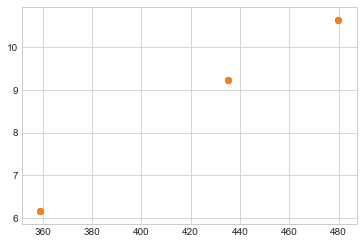

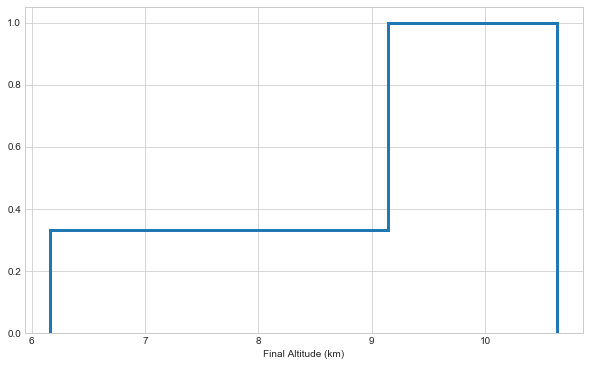

In [48]:
# plt.hist()
figsize=(10,6)
plt.scatter(vf, hf)

plt.scatter(vf, hf)

# plt.figure(5, figsize=figsize)
# plt.hist(hor_err, cumulative=True, histtype='step', bins='auto', linewidth=4, normed=True)
# plt.xlabel("Horizontal Error (km)")

plt.figure(6, figsize=figsize)
plt.hist(hf, cumulative=True, histtype='step', bins='auto', linewidth=3, normed=True)
plt.xlabel("Final Altitude (km)")

In [ ]:
sim.set_output(False)
collect = []
for dx0, sample in zip(*X0):
    print(dx0.shape)
    print(sample.shape)
    OL = ConvexPC(traj, 1e6) # never replans, just open loop essentially
    CL = ConvexPC(traj, tspan=10)
    res = sim.run(x0+dx0, [OL.controller, CL.controller], sample)
    collect.append(copy.deepcopy(sim.df))

(8,)
(4,)
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
(8,)
(4,)
Replanning...


E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in double_scalars
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
(8,)
(4,)
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
  

E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )
E:\Documents\EDL\EntryGuidance\Planet.py:113: RuntimeWarning: invalid value encountered in arccos
  PHI = np.sign(lonc-lon0)*arccos( (sin(latc) - sin(lat0)*cos(d13))/(cos(lat0)*sin(d13)) )


Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
(8,)
(4,)
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Replanning...
    ...done
Re